In [1]:
pref = 'knn_pretrain_dist_'
def prefix(dic,pref):
    for key in dic:
        dic[key] = [pref+scen for scen in dic[key]]
    return dic

In [33]:
from utils import flatten_list_of_list as flat
import copy
scen_folder = 'knn_pretrain_dist' #Folder in which all experiments are stored. 
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"] #"embdim7_epoch100"
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names = prefix(dict_file_names,pref)
print(dict_file_names['clump'])
#Exp names if need to change
dict_exp_names = copy.deepcopy(dict_file_names)
#Names to replace with
dict_new_names = copy.deepcopy(dict_exp_names)
dict_new_names['clump'] = flat([['clump1 \n (base)'],["clump%d"%i for i in range(2,8)]])
dict_new_names['embdim'] = ['emdim2 \n (base)',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_new_names['noise'] = ['noise1e-3 \n (base)','noise5e-3','noise1e-2','noise2e-2']
dict_new_names['ncon'] = ['ncon50','ncon100','ncon200 \n (base)','ncon300']

['knn_pretrain_dist_base', 'knn_pretrain_dist_clump2', 'knn_pretrain_dist_clump3', 'knn_pretrain_dist_clump4', 'knn_pretrain_dist_clump5', 'knn_pretrain_dist_clump6', 'knn_pretrain_dist_clump7']


In [19]:
#Paths
import os
from pathlib import Path
fp_repo = "/Users/roseline/Docs/AI/GITHUB/unsupervised-alignment"
#fp_repo = '/content/gdrive/My Drive/unsupervised-alignment-team-master'
fp_intersect = fp_repo / Path('python','assets','intersect')
fp_save = fp_repo / Path('save',scen_folder)
os.chdir(fp_repo / Path('python'))

In [20]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import time
from matplotlib import gridspec
import matplotlib
from matplotlib.ticker import MaxNLocator
#Custom
import utils
import models
#KERAS
import tensorflow as tf
import keras
from tensorflow.keras.models import load_model
sns.set(font_scale=1)

# Code to fetch data

In [21]:
def get_exps_dfs(fp_save,exp_names,file_names):
    #== Get path of save folder/ models and data
    n_exp = len(file_names)
    fp_runs_list = []
    fp_models_list = []
    for i in range(n_exp):
        save_folder = file_names[i]
        fp_runs_list.append(fp_save / Path(save_folder))
        fp_models_list.append(fp_save / Path(save_folder,'models'))
    #====Get params====
    dict_params_list = []
    for i in range(n_exp):
        fp_runs = fp_runs_list[i]
        with open(fp_runs /Path('dict_params.pickle'), 'rb') as handle:
            dict_params = pickle.load(handle)
            dict_params_list.append(dict_params)
    #display(pd.DataFrame(dict_params_list))
    df_params = pd.DataFrame(dict_params_list)
    ##========GET RESULTS==========
    df_all_res_list = []
    df_summary_res_list = []
    for i in range(n_exp):
        fp_runs = fp_runs_list[i]
        with open(str(fp_runs)+'/all_res.pickle', 'rb') as handle:
            all_res = pickle.load(handle)
        with open(str(fp_runs)+'/summary_res.pickle', 'rb') as handle:
            summary_res = pickle.load(handle)
            df_all_res = pd.DataFrame(utils.flatten_list_of_list(all_res))
            df_summary_res = pd.DataFrame(summary_res)
        df_all_res_list.append(df_all_res)
        df_summary_res_list.append(df_summary_res)
    df_all_res = pd.concat(df_all_res_list)
    df_summary_res = pd.concat(df_summary_res_list)
    #==Add columns for average accuracies to df_all_res
    df_all_res = add_avg_acc_columns(df_all_res)
    return df_all_res,df_summary_res, df_params
def add_avg_acc_columns(df_all_res):
    #==Add columns for average accuracies to df_all_res
    for s in ['1','5','10','half']:
        df_all_res['acc%s'%s] = 1/2 *(df_all_res['acc_f%s'%s]+df_all_res['acc_g%s'%s])
    return df_all_res
def get_exp_data_per_run(exp,df_epoch29_newfg,threshs,n_runs=10,n_restarts=100):
    df = utils.get_df(df_epoch29_newfg, exp = exp)
    #Loop through runs
    exp_data_per_run = np.zeros((n_runs,n_restarts))
    exp_n_good_per_run = np.zeros((n_runs,))
    for j in range(n_runs):
        thresh = threshs[j] #thresh for specific run
        df_run = utils.get_df(df, run = j)
        run_data =  np.array(list(df_run['acc1']))
        exp_data_per_run[j,:] = list(run_data) #1 row, 1 run. Transpose
        exp_n_good_per_run[j] = len(np.where(run_data>thresh)[0])
    return exp_data_per_run,exp_n_good_per_run
def get_exp_ceil_accs(exp,df_summary_res):
    df= utils.get_df(df_summary_res,exp=exp)
    ceil_accs = np.array(list(df['ceil_acc_1']))
    return ceil_accs
def get_useful_data_for_plotting(new_names,df_all_res,df_summary_res):
    '''
    Returns:
        all_exp_data (nexp,nruns,nrestart)
        all_ceil_accs (nexp,n_runs)
        n_good_per_run (nexp,n_runs)
    '''
    n_exp = len(new_names)
    #Filter df_all_res
    df_epoch29_newfg = utils.get_df(df_all_res, epoch=29, new_f=True, new_g=True)
    #Loop through exp
    all_ceil_accs = np.zeros((n_exp,10))
    n_good_per_run = np.zeros((n_exp,10)) #Each row is one exp
    all_exp_data = np.zeros((n_exp,10,100))
    for i in range(n_exp):
        exp = new_names[i]
        ceil_accs = get_exp_ceil_accs(exp,df_summary_res)
        threshs = 0.9*ceil_accs
        exp_data_per_run,exp_n_good_per_run = get_exp_data_per_run(exp,df_epoch29_newfg,threshs,n_runs=10,n_restarts=100)
        exp_data_all = exp_data_per_run.reshape(-1)
        #Store
        n_good_per_run[i,:] = exp_n_good_per_run
        all_ceil_accs[i,:]= ceil_accs
        all_exp_data[i,:,:] = exp_data_per_run
    return all_exp_data, all_ceil_accs,n_good_per_run
def get_dfs_from_key(key):
    file_names,exp_names,new_names = dict_file_names[key],dict_exp_names[key],dict_new_names[key]
    new_names = [n.replace(" \n (base)", "") for n in new_names]
    print(new_names)
    df_all_res,df_summary_res, df_params = get_exps_dfs(fp_save,exp_names,file_names)
    for df in [df_all_res,df_summary_res, df_params]:
            df["experiment_name"] = df["experiment_name"].replace(exp_names,new_names)
    return df_all_res,df_summary_res, df_params
def get_matches_data(scen,df_summary_res): #scen == exp == 'clump1'
    scen_matches_acc = list(df_summary_res[df_summary_res['experiment_name']==scen]['matches_acc'])
    scen_matches_acc = np.array(scen_matches_acc)
    avg_matches_acc= np.mean(scen_matches_acc)
    return avg_matches_acc,scen_matches_acc
def get_all_match_accs(new_names,df_all_res,df_summary_res):
    n_exp = len(new_names)
    all_match_accs = np.zeros((n_exp,10))
    n_exp = len(new_names)
    for i in range(n_exp):
        exp = new_names[i]
        _,match_accs = get_matches_data(exp,df_summary_res)
        all_match_accs[i,:] = match_accs
    return all_match_accs

# Code to plot

In [22]:
def outer_structure_match(n_exp,match_accs = True,bhist = False):
    wfig,hfig= min(n_exp/4 * 15,15), 4
    wr = 10* wfig/15 
    fig = plt.figure(figsize = (wfig,hfig)) 
    #==Split the grid
    #1 left 1 right
    outer_grid = gridspec.GridSpec(1,2,width_ratios=[wr, 1]) 
    outer_grid.update(wspace=0.15,hspace=0.5) 
    n_cols_bottom = 1 if not bhist else n_exp
    #Set up the left one (depends on if violin or hist) if hist only gs_bottom (1,n_exp)
    gs_left = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=outer_grid[0], height_ratios=[1e-1,1,1e-1,1,1e-1,7], hspace=0.4) #extra rows for titles
    gs_right = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=outer_grid[1],wspace=4)
    gs_toptop = gridspec.GridSpecFromSubplotSpec(1, n_exp, subplot_spec=gs_left[1])
    gs_top = gridspec.GridSpecFromSubplotSpec(1, n_exp, subplot_spec=gs_left[3])
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, n_cols_bottom, subplot_spec=gs_left[5])
    gs_toptop_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[0])
    gs_top_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[2])
    gs_bottom_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[4])
    #Set up axes to plot on
    axes_bottom = plt.subplot(gs_bottom[0]) if not bhist else [plt.subplot(gs_bottom[0,k]) for k in range(n_exp)]
    axes_runs = [plt.subplot(gs_top[0,k]) for k in range(n_exp)]
    axes_match = [plt.subplot(gs_toptop[0,k]) for k in range(n_exp)]
    ax_cb = plt.subplot(gs_right[0])
    ax_cb_match = plt.subplot(gs_right[1])
    #Some titles
    ax_toptop_title = plt.subplot(gs_toptop_title[0])
    ax_top_title = plt.subplot(gs_top_title[0])
    ax_bottom_title = plt.subplot(gs_bottom_title[0])
    ax_toptop_title.axis('off')
    ax_top_title.axis('off')
    ax_bottom_title.axis('off')
    ax_toptop_title.set_title("Surrogate accuracy per run",pad=-4,fontsize = FTSZ_TITLE)
    ax_top_title.set_title("Number of successful restart per run (1 cell per run)",pad=-4,fontsize = FTSZ_TITLE)
    ax_bottom_title.set_title("Accuracies and number of successful restart",pad = -7,fontsize = FTSZ_TITLE)
    return fig, axes_bottom, axes_runs, ax_cb , axes_match , ax_cb_match

In [23]:
#=== For both
def outer_structure(n_exp,bhist = False):
    wfig,hfig= min(n_exp/4 * 15,15), 4
    wr = 50* wfig/15 
    fig = plt.figure(figsize = (wfig,hfig)) 
    #==Split the grid
    #1 left 1 right
    outer_grid = gridspec.GridSpec(1,2,width_ratios=[wr, 1]) 
    outer_grid.update(wspace=0.15,hspace=0.5) 
    #Set up the left one (depends on if violin or hist) if hist only gs_bottom (1,n_exp)
    gs_left = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer_grid[0], height_ratios=[1e-1,1,1e-1,7], hspace=0.2) #extra rows for titles
    gs_right = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=outer_grid[1])
    n_cols_bottom = 1 if not bhist else n_exp
    gs_top = gridspec.GridSpecFromSubplotSpec(1, n_exp, subplot_spec=gs_left[1])
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, n_cols_bottom, subplot_spec=gs_left[3])
    gs_top_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[0])
    gs_bottom_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[2])
    #Set up axes to plot on
    axes_bottom = plt.subplot(gs_bottom[0]) if not bhist else [plt.subplot(gs_bottom[0,k]) for k in range(n_exp)]
    axes_runs = [plt.subplot(gs_top[0,k]) for k in range(n_exp)]
    ax_cb = plt.subplot(gs_right[0])
    #Some titles
    ax_top_title = plt.subplot(gs_top_title[0])
    ax_bottom_title = plt.subplot(gs_bottom_title[0])
    ax_top_title.axis('off')
    ax_bottom_title.axis('off')
    ax_top_title.set_title("Number of successful restart per run (1 cell per run)",pad=-4,fontsize = FTSZ_TITLE)
    ax_bottom_title.set_title("Accuracies and number of successful restart",pad = -7,fontsize = FTSZ_TITLE)
    return fig, axes_bottom, axes_runs, ax_cb
def plot_colorbar(ax,cf,title):
    ax.tick_params(axis=u'both', which=u'both',length=0, labelsize= FTSZ_YTICKS)
    ax.set_xlabel(title, rotation='vertical', fontsize=FTSZ_LABEL)
    ax.xaxis.set_label_coords(-0.9,3/4)
    cb = plt.colorbar(cf, cax=ax)
    cb.locator = MaxNLocator(integer=True)
    cb.update_ticks()

In [24]:
#=== VIOLIN
def plot_violin(ax,new_names,df_summary_res,df_all_res):
    df_epoch29_newfg = utils.get_df(df_all_res, epoch=29, new_f=True, new_g=True)
    sns.violinplot(x="experiment_name", y="acc1", data=df_epoch29_newfg,ax=ax, bw = 0.005, scale='count')
    ax.get_xaxis().get_label().set_vixible = False
    violin_add_ceil(ax,new_names,df_summary_res,df_all_res)
    ax.set_xlabel('')
    ax.set_ylabel('Top 1 accuracy', fontsize = FTSZ_LABEL)
    ax.tick_params(axis='x', which='major', labelsize=FTSZ_LABEL)
    ax.tick_params(axis='y', which='major', labelsize= FTSZ_YTICKS)
def plot_swarm(ax,df_all_res):
    df_epoch29_newfg = utils.get_df(df_all_res, epoch=29, new_f=True, new_g=True)
    sns.swarmplot(x="experiment_name", y="acc1", hue = 'run', data=df_epoch29_newfg,ax=ax,palette = 'dark')
#==Helpers
def violin_add_ceil(ax,new_names,df_summary_res,df_all_res):
    n_exp = len(new_names)
    #line/text coord
    xmins_lines,xmaxs_lines = violins_coord(n_exp)
    xmins_texts,xmaxs_texts = violins_coord(n_exp,ax)
    #Fetch useful data
    all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
    #Loop and add lines
    for i,exp in enumerate(new_names):
        #Fetch accuracy
        ceil_accs = all_ceil_accs[i]
        threshs_exp = 0.9 * ceil_accs
        tot_success = np.sum(n_good_per_run[i])
        #Val to plot
        ceil = np.mean(ceil_accs)
        thresh = 0.9*np.mean(ceil_accs)
        #plot lines
        ax.axhline(ceil, ls='--', color = 'k',xmin=xmins_lines[i], xmax=xmaxs_lines[i])
        ax.axhline(thresh, ls='--', color = 'k',xmin=xmins_lines[i], xmax=xmaxs_lines[i])
        #Plot text
        s = '%d'%tot_success
#         ax.text(xmaxs_texts[i],(ceil+thresh)/2,s,ha='left',va ='center',fontsize = FTSZ_TOT,fontweight = 'bold')
        ax.text(xmaxs_texts[i],thresh-0.01,s,ha='center',va ='top',fontsize = FTSZ_TOT,fontweight = 'bold')
def violins_coord(n_exp,ax=None):
    xlim0,xlim1 = (0,1) if ax is None else ax_violin.get_xlim() 
    totw = xlim1 - xlim0
    #settings
    step = 1/n_exp * totw
    w = 0.1 *totw
    centers = [xlim0+step*i+step/2 for i in range(n_exp)]
    xmins = [c-w/2 for c in centers]
    xmaxs = [c+w/2 for c in centers]    
    return xmins,xmaxs

In [25]:
#=== Run success
def get_run_success(axes,n_good_per_run,all_ceil_accs,cb_max_val = None):   
    mycmap = matplotlib.cm.get_cmap('RdYlGn')
    mycmap.set_under('k') #.set_bad('k')
    #Code
    n_exp = n_good_per_run.shape[0]
    n_runs = n_good_per_run.shape[1]
    max_val = np.max(n_good_per_run) if cb_max_val is None else cb_max_val
    for i in range(n_exp):
        Z = n_good_per_run[i][None,:]
        x = np.arange(0, n_runs+1, 1)  # len = 11
        y = np.arange(0, 2, 1)
        cf = axes[i].pcolormesh(x,y,Z, linewidths=0,cmap=mycmap,vmin=1, vmax=max_val) 
        #== y axis
        axes[i].yaxis.set_visible(False)
        #== x axis
        if i == 0:
            axes[i].yaxis.set_visible(True)
            axes[i].set_yticks([])
            xpos , ypos = -1,1           
        axes[i].set_xticks([]) 
    return cf #last plot

In [26]:
#Plot colormap matches accuracy
def plot_cm_match_accs(axes,all_match_accs):   
    mycmap = matplotlib.cm.get_cmap('RdYlGn')
    mycmap.set_under('k') #.set_bad('k')
    #Code
    n_exp = all_match_accs.shape[0]
    n_runs = all_match_accs.shape[1]
    max_val = 1 #np.max(all_match_accs)
    for i in range(n_exp):
        Z = all_match_accs[i][None,:]
        x = np.arange(0, n_runs+1, 1)  # len = 11
        y = np.arange(0, 2, 1)
        cf = axes[i].pcolormesh(x,y,Z, linewidths=0,cmap=mycmap,vmin=0.01, vmax=max_val) 
        #== y axis
        axes[i].yaxis.set_visible(False)
        #== x axis
        if i == 0:
            axes[i].yaxis.set_visible(True)
            axes[i].set_yticks([])
            xpos , ypos = -1,1           
        axes[i].set_xticks([]) 
    return cf #last plot

In [27]:
#Hist
def plot_hist_on_axes(axes_hist,new_names,all_exp_data,all_ceil_accs,n_good_per_run, split_by_run = False):  
    n_exp = len(all_exp_data)
    #bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    step = 0.1
    bins = np.arange(0,1+step,step)
    for i in range(n_exp):
        ceil_accs = all_ceil_accs[i]
        exp_data_per_run = all_exp_data[i]
        exp_data_all = exp_data_per_run.reshape(-1) #np.sum(exp_data_per_run,axis=1)
        counts = np.histogram(exp_data_all,bins = bins)[0]
        if not split_by_run:
            sns.distplot(exp_data_all,ax = axes_hist[i],bins = bins,kde = False, norm_hist= True, vertical=True)
            set_labels_all(axes_hist[i],counts)
        else:
            axes_hist[i].hist(exp_data_per_run.T,density=True, stacked=True,bins = bins,  orientation="horizontal",linewidth=0)
            set_labels_per_run(axes_hist[i],counts,len(bins)-1,10)
        #===Ax setting==
        axes_hist[i].set_xticks([])
        axes_hist[i].set_xlabel(new_names[i],fontsize=FTSZ_LABEL) #axes[i].set_title(exp)
        axes_hist[i].set_xlim(0, 12)
        axes_hist[i].set_ylim(0, 1.01)
        if i != 0:
            axes_hist[i].grid(True)
            axes_hist[i].set_yticklabels([])
        #==Ceiling accuracies - min max + thresh
        leg = False #if i == n_exp-1 else False
        draw_ceil_lines(axes_hist[i],all_ceil_accs[i],n_good_per_run[i],leg = leg)
    #===General settings            
    axes_hist[0].yaxis.set_visible(True)
    axes_hist[0].set_ylabel('top 1 accuracy', fontsize=FTSZ_LABEL)
    #plt.tight_layout(pad=0.2)
#### Helper
def draw_ceil_lines(ax,ceil_accs,exp_n_good_per_run,leg = False):
    #all_ceil_accs (n_exp or axes,n_runs)
    ceil = np.mean(ceil_accs)
    thresh = 0.9*np.min(ceil_accs)
    ax.axhline(ceil, ls='--', color = 'k') #,label = 'ceil')
    ax.axhline(thresh, ls='--', color = 'k') #,label = 'thresh')
    n_above = np.sum(exp_n_good_per_run)
    #ax.set_title('Total success: %d'%n_above,fontweight="bold", fontsize=FTSZ_TITLE)
    ax.set_title('%d'%n_above,fontweight="bold", fontsize=FTSZ_TOT)
    if leg:
        #ax.legend(loc='upper right', frameon=False) 
        xmin,xmax = ax.get_xlim()
        xtext,ypad = xmax,0.01
        ax.text(xtext,ceil-ypad,'ceiling', ha='right',va = 'top',fontsize = FTSZ_COUNT)
        ax.text(xtext,thresh-ypad,'threshold', ha='right',va = 'top',fontsize = FTSZ_COUNT)
def set_labels_all(ax,counts):
    idx = np.arange(0,len(counts))
    idx = [0] 
    h = 0
    for k,p in enumerate(ax.patches):
        if k in idx:
            w = p.get_width()
            s = counts[k]
            ax.text(w+0.5,h+0.03,'%s'%s,fontsize = FTSZ_COUNT) 
        h += p.get_height()
def set_labels_per_run(ax,counts,n_bins,n_stacked):
    #==Get width
    ws = np.zeros((n_bins,n_stacked))
    r_w = -1
    for k,p in enumerate(ax.patches):
        if k % n_stacked == 0 :
            r_w +=1
            c_w = 0
        else: 
            c_w +=1
        ws[r_w,c_w]=w = p.get_width() 
    #==Write labels
    h = 0
    for k in range(n_stacked):
        s = counts[k]
        w = np.sum(ws[:,k])
        ax.text(w+0.5,h+0.03,'%s'%s,fontsize = FTSZ_COUNT) 
        h += p.get_height()

# STgs

In [28]:
FTSZ_YTICKS = 13 #Colorbar + y on violin /hist
FTSZ_LABEL = 15 #Clumps + title of y for violin and colorbar
FTSZ_TITLE = 15 #(2 titles)
FTSZ_TOT = 15 #Total number of successes
FTSZ_COUNT = 12

In [29]:
# keys = ['clump','embdim','noise','ncon']
# for key in keys:
#     df_all_res,df_summary_res, df_params = get_dfs_from_key(key)
#     arr = np.array(df_summary_res['sd_run']).reshape(-1,10)
#     print(arr)

# All plots

*****************************
==========clump=============
*****************************


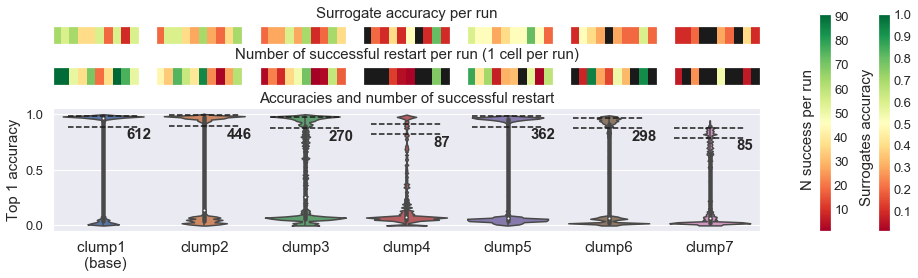

*****************************
==========embdim=============
*****************************


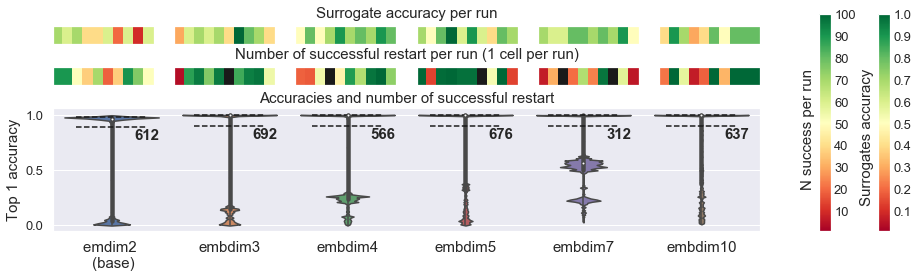

*****************************
==========noise=============
*****************************


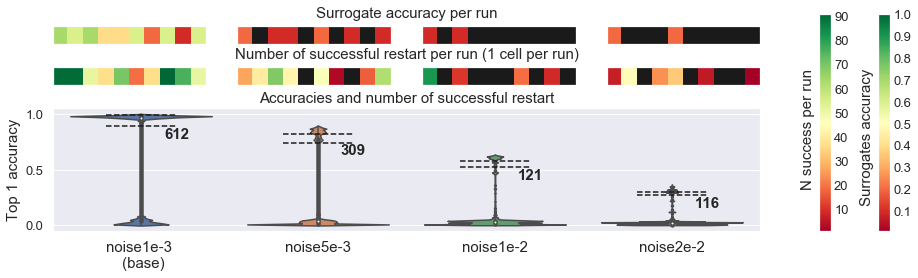

*****************************
==========ncon=============
*****************************


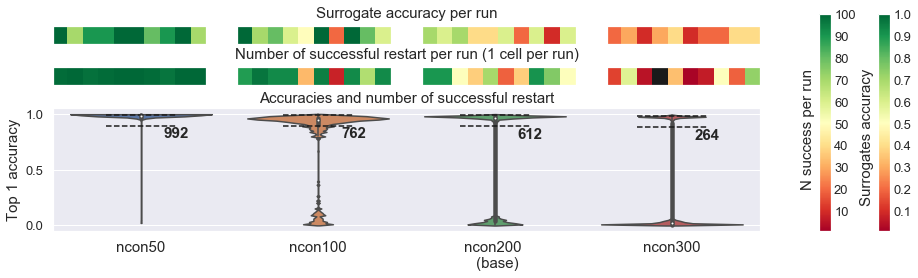

In [35]:
exceptions = []
for key in dict_file_names: 
# for key in ['clump']:
    if key not in exceptions:
        print('*****************************')
        print('==========%s============='%key)
        print('*****************************')
        file_names, exp_names, new_names = dict_file_names[key],dict_exp_names[key],dict_new_names[key]
        df_all_res,df_summary_res, df_params = get_exps_dfs(fp_save,exp_names,file_names)
        for df in [df_all_res,df_summary_res]:
            df["experiment_name"] = df["experiment_name"].replace(exp_names,new_names)
        #Fetch useful data
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        #Get outer structure
        n_exp = len(file_names)
        #fig, ax_violin, axes_runs, ax_cb = outer_structure(n_exp,bhist=False)
        fig, ax_violin, axes_runs, ax_cb , axes_match , ax_cb_match = outer_structure_match(n_exp,bhist=False)
        #Plot
        plot_violin(ax_violin,new_names,df_summary_res,df_all_res)
        cf = get_run_success(axes_runs,n_good_per_run,all_ceil_accs)
        plot_colorbar(ax_cb,cf,'N success per run')
        cf_match = plot_cm_match_accs(axes_match,all_match_accs)
        plot_colorbar(ax_cb_match,cf_match,'Surrogates accuracy')
        plt.show()

In [45]:
# exceptions = ['noise','ncon']
# for key in dict_file_names: 
#     if key not in exceptions:
#         print('*****************************')
#         print('==========%s============='%key)
#         print('*****************************')
#         file_names, exp_names, new_names = dict_file_names[key],dict_exp_names[key],dict_new_names[key]
#         df_all_res,df_summary_res, df_params = get_exps_dfs(fp_save,exp_names,file_names)
#         for df in [df_all_res,df_summary_res]:
#             df["experiment_name"] = df["experiment_name"].replace(exp_names,new_names)
#         #Fetch useful data
#         all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
#         #Get outer structure
#         n_exp = len(file_names)
#         fig, axes_hist, axes_runs, ax_cb = outer_structure(n_exp,bhist=True)
#         #Plot
#         plot_hist_on_axes(axes_hist,new_names,all_exp_data,all_ceil_accs,n_good_per_run, split_by_run = False)
#         cf = get_run_success(axes_runs,n_good_per_run,all_ceil_accs)
#         plot_colorbar(ax_cb,cf)
#         plt.show()

# BAR CHART

In [50]:
#GEt ALL ALL DATA
exceptions = ['noise','ncon'] 
all_n_good_per_run = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        file_names,exp_names,new_names = dict_file_names[key],dict_exp_names[key],dict_new_names[key]
        new_names = [n.replace(" \n (base)", "") for n in new_names]
        all_labels.append(new_names)
        df_all_res,df_summary_res, df_params = get_exps_dfs(fp_save,exp_names,file_names)
        for df in [df_all_res,df_summary_res]:
                df["experiment_name"] = df["experiment_name"].replace(exp_names,new_names)
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
print(all_n_good_per_run.shape)

(14, 10)


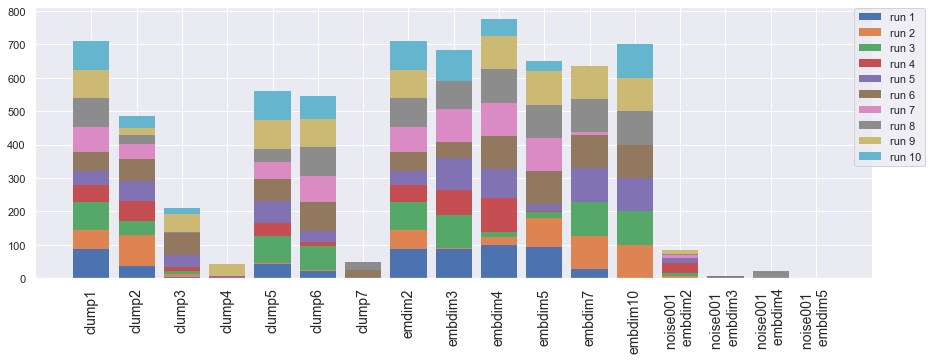

In [41]:
#PLOT
n_runs = 10
fig = plt.figure(figsize = (15,5)) 
for i in range(n_runs):
    plt.bar(all_labels,all_n_good_per_run[:,i],bottom=np.sum(all_n_good_per_run[:,:i],axis=1),label = 'run %d'%(i+1),linewidth=0)
    plt.xticks(rotation=90)
plt.xticks(fontsize=14)
plt.legend(loc="upper right",bbox_to_anchor=(1.07, 1.015))
plt.show()